In [9]:
import torch
from torch.utils.data import DataLoader

In [10]:
import sys
sys.path.append('/home/joao.pires/MPP/neural_mpp/EM/Refact/')
from models import NormalizingFlow
from sweep import HawkesSweep

In [11]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

n_points = 600
time = np.arange(n_points)


X1 = np.random.binomial(1, 0.6, n_points)
X2 = np.zeros(n_points)
X3 = np.zeros(n_points)


for t in range(1, n_points):
    # X2 is more likely to happen if X1 happened in the previous step
    X2[t] = np.random.binomial(1, 0.5 * X1[t-1] + 0.2)
    # X3 is more likely to happen if X2 happened in the previous step
    X3[t] = np.random.binomial(1, 0.7 * X2[t-1] + 0.2)



X1 = [time[i] for i in range(len(X1)) if X1[i] > 0]
X2 = [time[i] + 0.1 for i in range(len(X2)) if X2[i] > 0]
X3 = [time[i] + 0.2 for i in range(len(X3)) if X3[i] > 0]

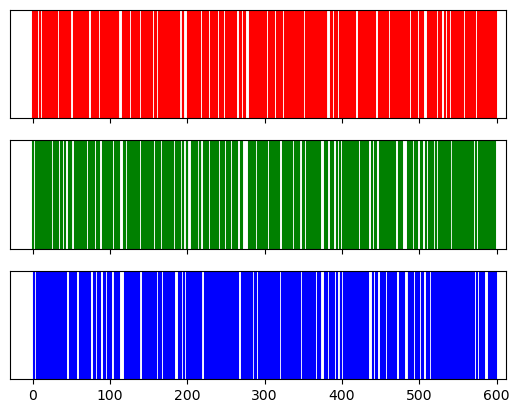

In [12]:
def _plot_tick_bars(timestamps_i, ax, color):
    for t in timestamps_i:
        ax.axvline(x=t, color = color)
    # ax.set_title(label, fontsize=20)
    ax.get_yaxis().set_visible(False)
def _plot_tick_bars_causes(timestamps_i, ax, cause):
    colors = ['red', 'green', 'blue']
    for idx, t in enumerate(timestamps_i):
        cause_ = torch.argmax(cause[idx]).item()
        ax.axvline(x=t, color = colors[cause_])
    ax.get_yaxis().set_visible(False)

fig, ax = plt.subplots(nrows = 3, sharex = True)

_plot_tick_bars(X1, ax[0], color = 'red')
_plot_tick_bars(X2, ax[1], color = 'green')
_plot_tick_bars(X3, ax[2], color = 'blue')

In [13]:
X1_ = torch.tensor(X1.copy(), dtype = torch.float32)
X2_ = torch.tensor(X2.copy(), dtype = torch.float32)
X3_ = torch.tensor(X3.copy(), dtype = torch.float32)
processes = [X1_, X2_, X3_]

In [231]:
import torch.nn as nn
import torch.nn.functional as F
class GrangerMPP(nn.Module):

    def __init__(self, Process):

        super().__init__()

        self.Process = Process
        self.n_processes = self.Process.n_processes
        self.memory_dim = self.Process.memory_dim
        self.GrangerMatrix = nn.Parameter((torch.empty(self.n_processes, self.n_processes)))
        nn.init.normal_(self.GrangerMatrix, mean=0.5, std=0.1) 

        self.models = nn.ModuleList([NormalizingFlow(num_features = 1, memory_size = self.memory_dim, hidden_dim = 32, num_layers = 4) for i in range(self.n_processes)])
        self.optimizers = [torch.optim.Adam(list(self.models[i].parameters()), lr=1e-4, weight_decay = 1e-5) for i in range(self.n_processes)]
        self.g_optimizer = torch.optim.Adam([self.GrangerMatrix], lr = 1e-3, weight_decay=1e-5)
        self.log_GrangerMatrix = []
        self.sweep_dict = self.Process.make_dict()


    def em_step(self, n_steps):
        
        dic = {}
        self.causes = [[] for _ in range(self.n_processes)]
        for i in range(self.n_processes):
            dic[i] = []


        taus = torch.linspace(2.0, 1.0, steps = n_steps)
        
        for self.step in range(n_steps):
          for i_proc in range(self.n_processes):
              self.causes[i_proc] = []
              curr = processes[i_proc]
              len_curr = len(curr)
              idx_start = 0
              while idx_start < len_curr:
                self.num_events = 5
                events = self.Process.get_events(self.sweep_dict, i_proc, idx_start, self.num_events) 
                self.events = events
                for _, (X, plausible_cause, time_idx) in enumerate(events):
                    
                    possible_times =  time_idx.unique()
                    app = []
                    
                    for _, val in enumerate(possible_times):
                        where_ = torch.where(time_idx == val)[0]
                        app.append(plausible_cause[where_])
                    
                
                    gumbel = self.sample(self.num_events, i_proc, tau = taus[self.step])
                    
                    cause_rank_list = []
                    
                    for pos, values in enumerate(app):
                        curr_probabilities = gumbel[pos]
                        num_of_plausible_causes = len(values)
                        if num_of_plausible_causes != 1:
                            renormalized_ = curr_probabilities[values]
                            renormalized_ = renormalized_/renormalized_.sum()
                        else:
                            renormalized_ = torch.tensor(1)
                        cause_rank_list.append(renormalized_)
                    
                    
                    cause_rank_tensor = torch.cat([t.unsqueeze(0) if t.dim() == 0 else t for t in cause_rank_list])
                    
                    self.cause_rank_tensor = cause_rank_tensor
                    self.causes[i_proc].append((cause_rank_tensor, plausible_cause))
                    
                    normalizing_len = 1/len_curr * torch.tensor([len(processes[i]) for i in plausible_cause])
                    
                    
                    X = X.unsqueeze(-1)
                    loss = self.m_step(i_proc, X, self.cause_rank_tensor, normalizing_len)
                    dic[i_proc].append(loss)

                    idx_start += self.num_events

              if (self.step + 1) % 5 == 0 or self.step == 0:
                  print(f'Step: {self.step + 1}, Model: {i_proc}, Loss: {loss}')


        return dic

    def m_step(self, i_proc, X, cause_rank_tensor, normalizing_len):
        
        model = self.models[i_proc]
        self.optimizers[i_proc].zero_grad()
        self.g_optimizer.zero_grad()
        batch_size, memory, features = X.size()
        z, logp = model.log_prob(X)
        loss = -1*logp

        loss_rnn = (normalizing_len * loss * cause_rank_tensor).sum()/batch_size  + -1*(normalizing_len*torch.log(cause_rank_tensor + 1e-7)).sum()/batch_size + 0.001*self.GrangerMatrix[i_proc].norm(p=1)


        if not (torch.isnan(loss_rnn) | torch.isinf(loss_rnn)):

            self.log_GrangerMatrix.append(self.GrangerMatrix.clone())
            
            loss_rnn.backward(retain_graph = True)

            self.optimizers[i_proc].step()
            self.g_optimizer.step()
            self.log_GrangerMatrix.append(self.GrangerMatrix.clone().detach())


        else:
            print(f'NaN found in epoch: {self.step}')

        return loss_rnn.item()

    def sample(self, num_events, i_proc, tau):

      in_ = self.GrangerMatrix[i_proc]
      rv = []
      for i in range(num_events):
        cause = F.gumbel_softmax(
            in_,
            tau = tau,
            hard = False
        )
        rv.append(cause)

    #   self.causes[i_proc].append(rv)

      return rv




In [85]:
hk = HawkesSweep(processes, 4)

d = hk.make_dict()

In [232]:
granger = GrangerMPP(hk)

In [233]:
l = granger.em_step(75)

Step: 1, Model: 0, Loss: 5.664106845855713
Step: 1, Model: 1, Loss: 5.886013984680176
Step: 1, Model: 2, Loss: 5.313446998596191
Step: 5, Model: 0, Loss: 4.046972751617432
Step: 5, Model: 1, Loss: 4.41989278793335
Step: 5, Model: 2, Loss: 3.6811487674713135
Step: 10, Model: 0, Loss: 3.8308193683624268
Step: 10, Model: 1, Loss: 4.144810676574707
Step: 10, Model: 2, Loss: 3.3519253730773926
Step: 15, Model: 0, Loss: 3.5043530464172363
Step: 15, Model: 1, Loss: 3.0600171089172363
Step: 15, Model: 2, Loss: 2.910295248031616
Step: 20, Model: 0, Loss: 3.2289230823516846
Step: 20, Model: 1, Loss: 2.929093360900879
Step: 20, Model: 2, Loss: 2.867211103439331
Step: 25, Model: 0, Loss: 2.6297240257263184
Step: 25, Model: 1, Loss: 3.3215441703796387
Step: 25, Model: 2, Loss: 2.834228992462158
Step: 30, Model: 0, Loss: 2.6103506088256836
Step: 30, Model: 1, Loss: 3.0180368423461914
Step: 30, Model: 2, Loss: 2.6144564151763916
Step: 35, Model: 0, Loss: 2.368464231491089
Step: 35, Model: 1, Loss: 3.

Len of losses: [5250, 4575, 4950]


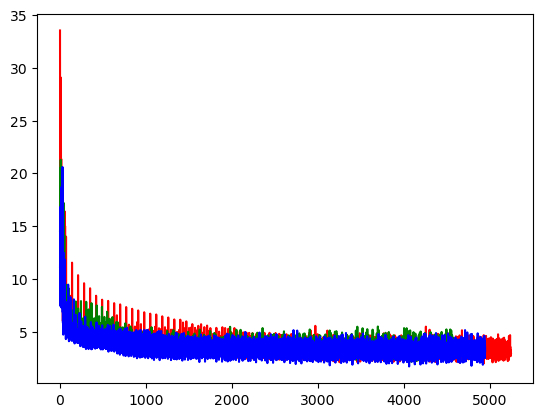

In [234]:
colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(l[i], color = colors[i])

t = [len(l[i]) for i in range(3)]

print(f'Len of losses: {t}')

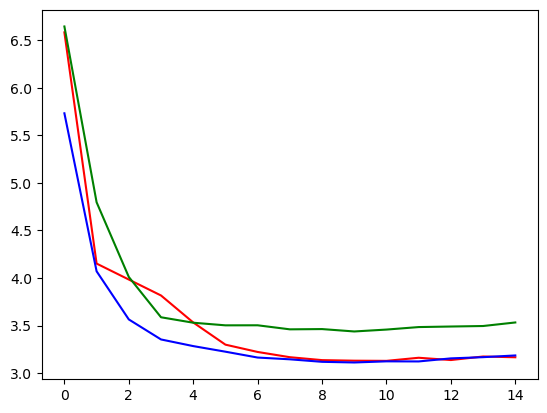

In [235]:
final = []
for proc in range(3):
    proc_size = len(processes[proc])
    loss_size = len(l[proc])
    temp = [ sum(l[proc][i:i + proc_size])/proc_size for i in range(0, loss_size - proc_size, proc_size)]
    final.append(temp)

colors = ['red', 'green', 'blue']
for i in range(3):
    plt.plot(final[i], color = colors[i])

In [167]:
frames_to_plot = np.arange(0, len(imgs), 150)
len(frames_to_plot)

197

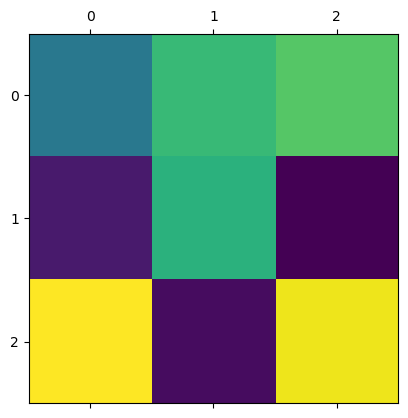

In [189]:
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


# Set up the figure and axis for animation
fig, ax = plt.subplots()
cax = ax.matshow(imgs[0], cmap='viridis')  # Initial frame with colormap

# Update function for each frame in the animation
def update(frame):
    cax.set_array(imgs[frame])
    return [cax]

# Create the animation
fps = 15
animation__ = FuncAnimation(fig, update, frames=frames_to_plot, interval= 13, blit=True)

# Save as GIF (requires Pillow or imagemagick)
# animation.save('matrix_evolution.gif', writer='pillow', fps=1113)


In [185]:
fps = 15
len(frames_to_plot)/fps

13.133333333333333

In [175]:
from IPython.display import HTML
HTML(animation__.to_jshtml(fps=15))

In [6]:
class WoldSweep(Sweep):
    def construct_wold_dict(self):
        dict = {}

        events = []
        for id, process in enumerate(self.processes):
            for t in process:
                events.append((t.item(), id))

        events.sort()

        deltas = {}
        last = {}
        cur = -1

        for t, id in events:
            dict[t] = {}
            deltas[id] = Memory(self.memory_dim)
            last[id] = [0, 0]

        for t, id in events:
            if t != cur:
                
                # updating
                cur = t
                for _id, _delta in deltas.items():
                    dict[cur][_id] = _delta.copy()
            
            last[id][1] = last[id][0]
            last[id][0] = t
            if last[id][1] != 0:
                deltas[id].push(last[id][0] - last[id][1])
            
        return dict
        
    # TODO: check idx_start semantics
    def make_dict(self):
        wold = self.construct_wold_dict()
        dic = {}
        for i in range(self.n_processes):
            target = self.processes[i]
            dic[i] = {}
            #for j in range(self.n_processes):
            #    cause = self.processes[j]
            #    dic[i][j] = self.sweep(target, cause)
            ret = {}
            for _t in target:
                t = _t.item()
                for j in range(self.n_processes):
                    if j not in ret:
                        ret[j] = []
                    #print(t, j, wold[t][j])
                    #return None
                    if len(wold[t][j]) < self.memory_dim:
                        ret[j].append([-1] * self.memory_dim)
                    else:
                        ret[j].append(wold[t][j])

            #return None
            for j in range(self.n_processes):
                dic[i][j] = torch.tensor(ret[j], dtype=torch.float)

        return dic


In [7]:
wd = WoldSweep(torch.tensor([[i for i in range(6)], [i for i in range(0, 6*4, 4)]]), 2)

wd.make_dict()

{0: {0: tensor([[-1., -1.],
          [-1., -1.],
          [-1., -1.],
          [-1., -1.],
          [ 1.,  1.],
          [ 1.,  1.]]),
  1: tensor([[-1., -1.],
          [-1., -1.],
          [-1., -1.],
          [-1., -1.],
          [-1., -1.],
          [-1., -1.]])},
 1: {0: tensor([[-1., -1.],
          [ 1.,  1.],
          [ 1.,  1.],
          [ 1.,  1.],
          [ 1.,  1.],
          [ 1.,  1.]]),
  1: tensor([[-1., -1.],
          [-1., -1.],
          [-1., -1.],
          [-1., -1.],
          [ 4.,  4.],
          [ 4.,  4.]])}}